## Исследование данных

In [1]:
# Подключаем необходимые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
# Подключаемся к Google-диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Загружаем данные
base = '/content/drive/MyDrive/machine-learning/'
exchange_data = pd.read_parquet(base + 'historical_currency_exchange.parquet')
transaction_data = pd.read_parquet(base + 'transaction_fraud_data.parquet')

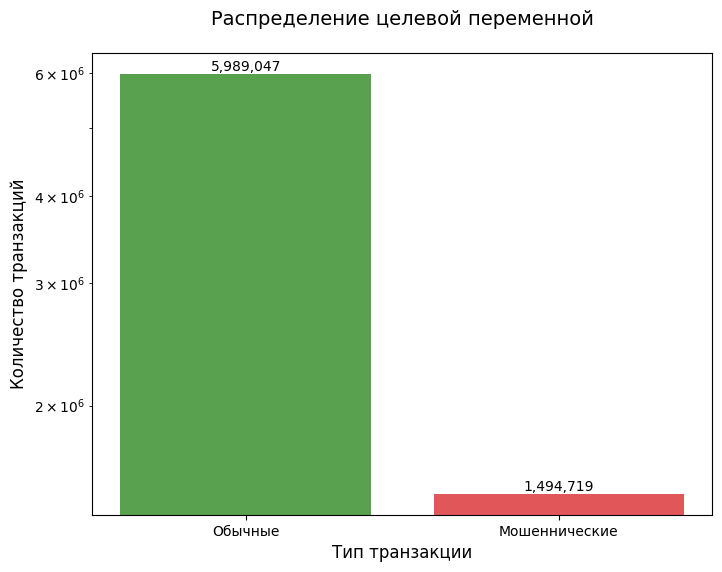

In [4]:
# Подсчет количества мошеннических и обычных транзакций
fraud_transactions_count = transaction_data['is_fraud'].value_counts()

# Создание графика
plt.figure(figsize=(8, 6))
bars = plt.bar(fraud_transactions_count.index, fraud_transactions_count.values, color=['#59a14f', '#e15759'])

# Установка логарифмической шкалы
plt.yscale('log')

# Настройка подписей
plt.xticks([False, True], ['Обычные', 'Мошеннические'])
plt.xlabel('Тип транзакции', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.title('Распределение целевой переменной', fontsize=14, pad=20)

# Добавление значений над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:,}',
             ha='center', va='bottom')

plt.show()

🔎 Ключевые наблюдения:

1. **Дисбаланс классов**:
   - Обычные транзакции: ~1.5 млн
   - Мошеннические транзакции: ~6 млн

2. **Проблемы**:
   - Модель будет склонна к смещению (bias) в сторону обычных транзакций
   - Традиционные метрики (Accuracy) будут неинформативны

3. **Рекомендации**:
   - Использовать метрики: **Precision, Recall, F1, ROC-AUC**
   - Применить методы борьбы с дисбалансом:
     - Взвешивание классов (`class_weight='balanced'`)
     - Стратифицированная выборка
     - SMOTE / ADASYN (аугментация минорного класса)
     - Ансамбли (например, BalancedRandomForest)

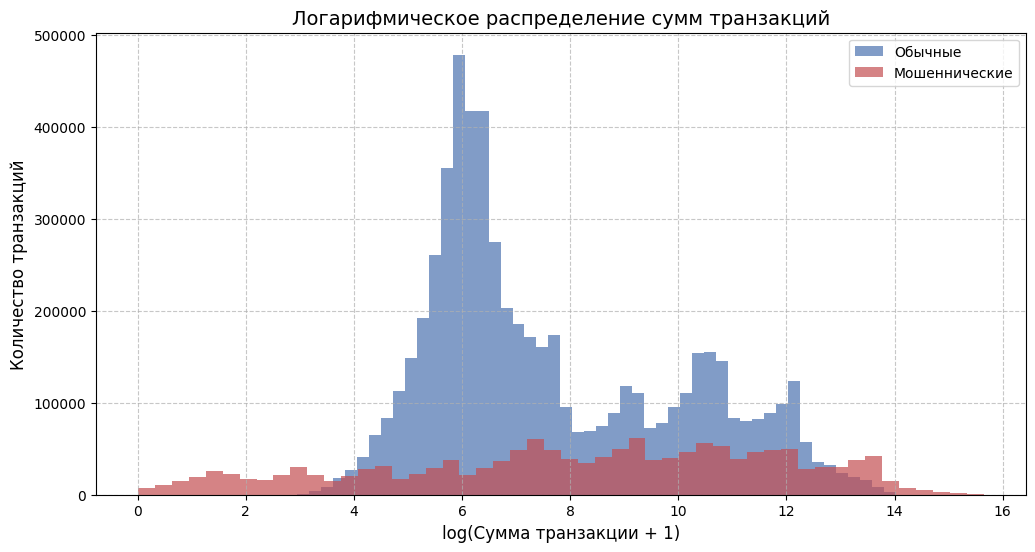

In [5]:
plt.figure(figsize=(12, 6))

# Разделяем на мошеннические и обычные
fraud_log = np.log1p(transaction_data[transaction_data['is_fraud']]['amount'])
normal_log = np.log1p(transaction_data[~transaction_data['is_fraud']]['amount'])

# Строим гистограммы
plt.hist(normal_log, bins=50, alpha=0.7, label='Обычные', color='#4c72b0')
plt.hist(fraud_log, bins=50, alpha=0.7, label='Мошеннические', color='#c44e52')

plt.title('Логарифмическое распределение сумм транзакций', fontsize=14)
plt.xlabel('log(Сумма транзакции + 1)', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

🔎 Ключевые наблюдения:

1. **Различие в распределениях**: Мошеннические транзакции имеют более "тяжелые хвосты" — это означает, что среди них чаще встречаются крупные суммы по сравнению с обычными операциями

2. **Выводы**: Большие суммы транзакций могут быть индикатором мошенничества

3. **Рекомендации**: В правилах antifraud-системы стоит уделять особое внимание аномально высоким суммам, особенно если они сочетаются с другими риск-факторами

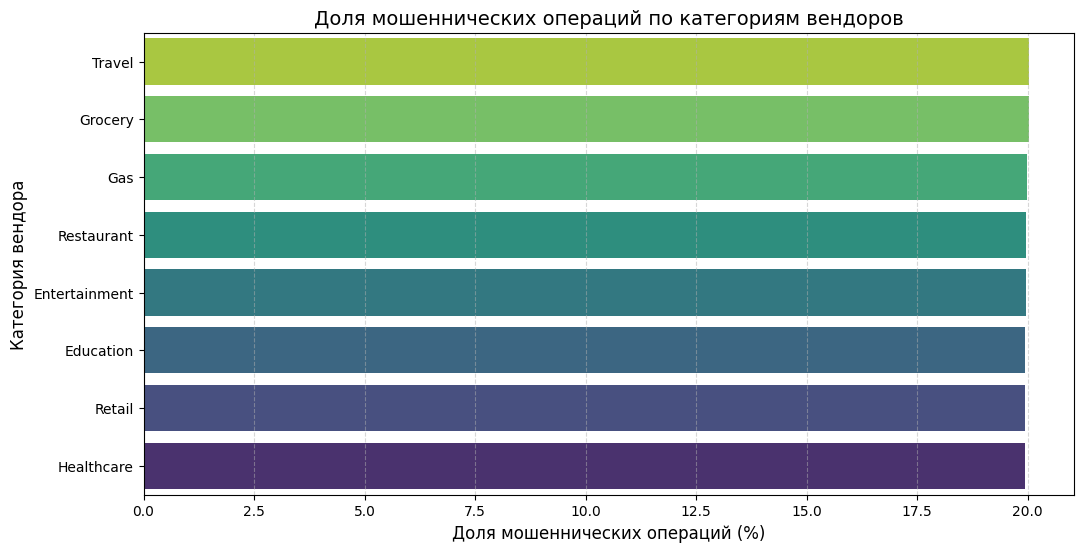

In [6]:
plt.figure(figsize=(12, 6))
fraud_by_category = transaction_data.groupby('vendor_category')['is_fraud'].mean().sort_values(ascending=False) * 100
sns.barplot(x=fraud_by_category.values, y=fraud_by_category.index, hue=fraud_by_category.index, palette='viridis_r')
plt.title('Доля мошеннических операций по категориям вендоров', fontsize=14)
plt.xlabel('Доля мошеннических операций (%)', fontsize=12)
plt.ylabel('Категория вендора', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

🔎 Ключевые наблюдения:
1. Доля мошеннических операций примерно равна у всех категорий вендоров (~20%). Можно предположить, что это скорее связано с особенностью выборки, нежели с реальными данными. В реальной жизни зависимость между категорией вендора и долей мошеннических операций есть.
2. Категории "Путешествия" и "Продуктовые магазины" все же выделяются как более рискованные — в них доля мошенничества несколько выше, чем, в других категориях.

In [7]:
# Словарь для перевода дней недели
weekday_translation = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}

# Преобразуем timestamp и переводим дни недели
transaction_data['hour'] = transaction_data['timestamp'].dt.hour
transaction_data['day_of_week'] = transaction_data['timestamp'].dt.day_name().map(weekday_translation)
transaction_data['is_weekend'] = transaction_data['timestamp'].dt.dayofweek >= 5

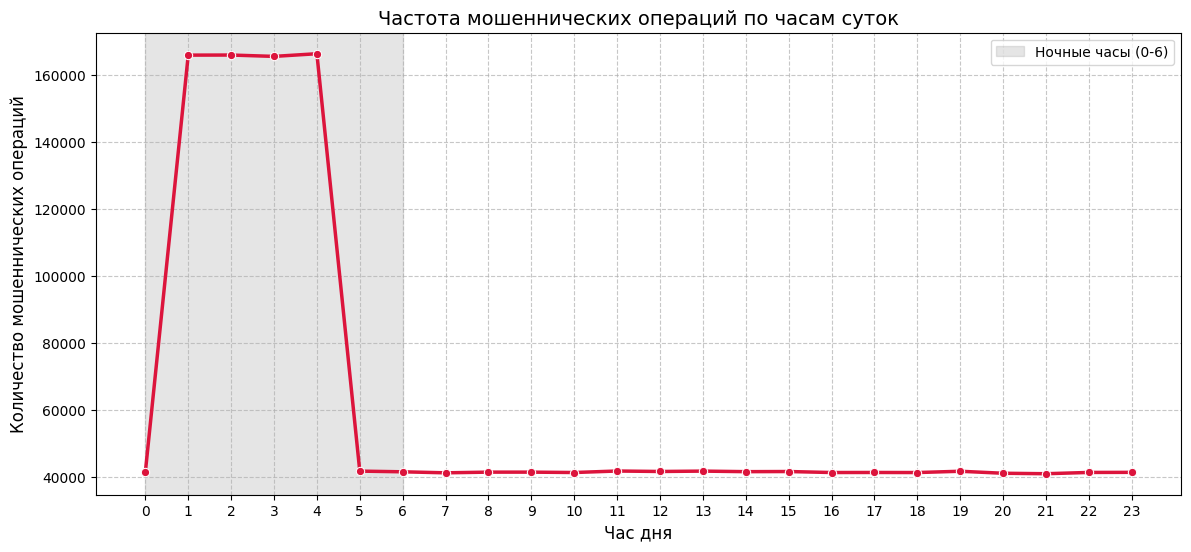

In [8]:
plt.figure(figsize=(14, 6))
hourly_fraud = transaction_data[transaction_data['is_fraud']].groupby('hour').size()
sns.lineplot(x=hourly_fraud.index, y=hourly_fraud.values,
             marker='o', color='crimson', linewidth=2.5)
plt.title('Частота мошеннических операций по часам суток', fontsize=14)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Количество мошеннических операций', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvspan(0, 6, color='gray', alpha=0.2, label='Ночные часы (0-6)')
plt.legend()
plt.show()

🔎 Ключевые наблюдения:
1. Пик мошеннической активности приходится на ночные часы (с 12 ночи до 5 утра). Это типичный паттерн: злоумышленники используют периоды низкой активности клиентов и персонала

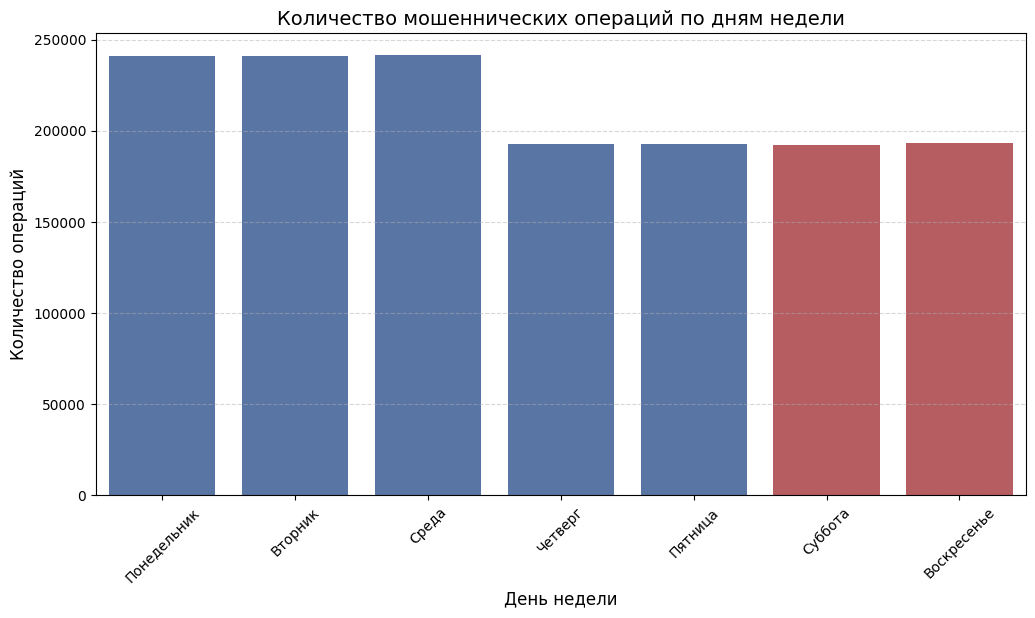

In [9]:
plt.figure(figsize=(12, 6))
weekday_order_ru = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
daily_fraud = transaction_data[transaction_data['is_fraud']]['day_of_week'].value_counts().reindex(weekday_order_ru)
sns.barplot(x=daily_fraud.index, y=daily_fraud.values, hue=daily_fraud.index,
            palette=['#4c72b0' if d not in ['Суббота', 'Воскресенье'] else '#c44e52' for d in weekday_order_ru])
plt.title('Количество мошеннических операций по дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество операций', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

🔎 Ключевые наблюдения:
1. Пик мошеннических операций приходится на период с понедельника по среду. Вероятно, это также связано с тем, что мошенники используют периоды низкой активности клиентов для осуществления нелегальных операций. Или же у них тоже нормированный рабочий график с выходными днями.

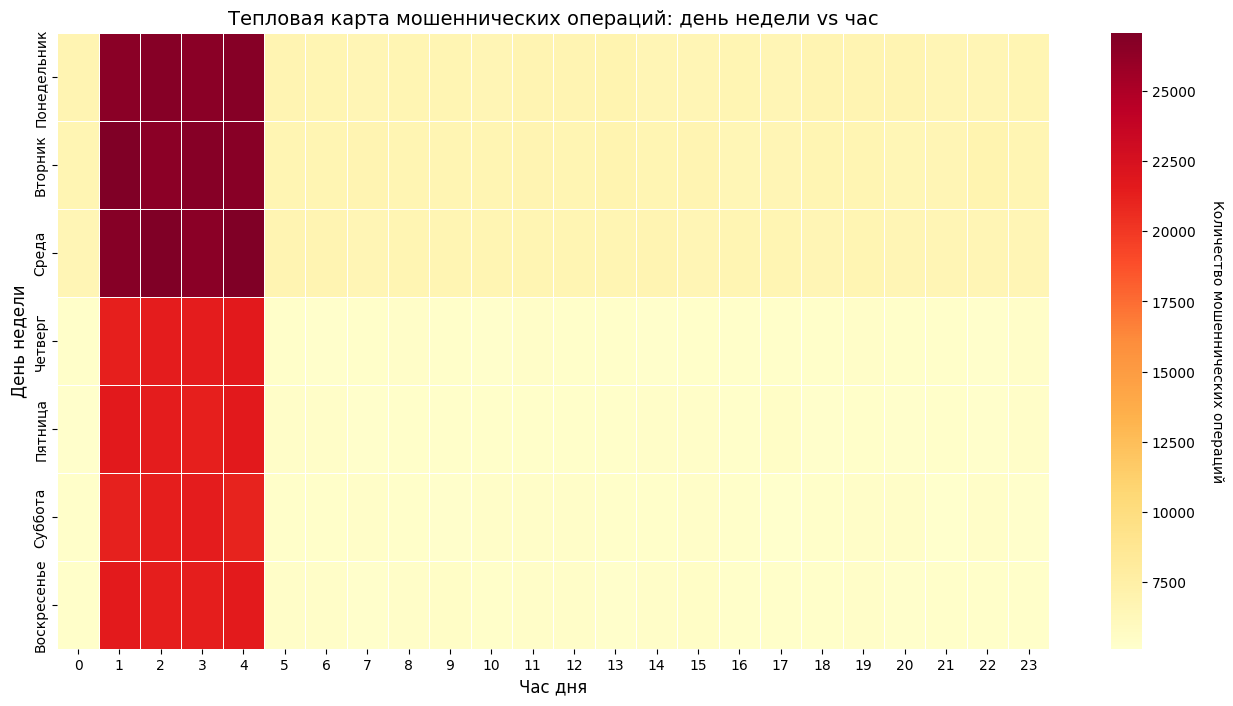

In [10]:
plt.figure(figsize=(16, 8))
fraud_heatmap = transaction_data[transaction_data['is_fraud']].groupby(['day_of_week', 'hour']).size().unstack().reindex(weekday_order_ru)

# Строим heatmap без аннотаций, но с colorbar
ax = sns.heatmap(
    fraud_heatmap,
    cmap='YlOrRd',
    linewidths=0.5,
    annot=False,  # Отключаем аннотации в ячейках
    cbar=True,    # Включаем цветовую шкалу
    cbar_kws={'label': 'Количество транзакций'}
)

plt.title('Тепловая карта мошеннических операций: день недели vs час', fontsize=14)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('День недели', fontsize=12)

# Добавляем пояснение по цветам в легенде
cbar = ax.collections[0].colorbar
cbar.set_label('Количество мошеннических операций', rotation=270, labelpad=20)

plt.show()

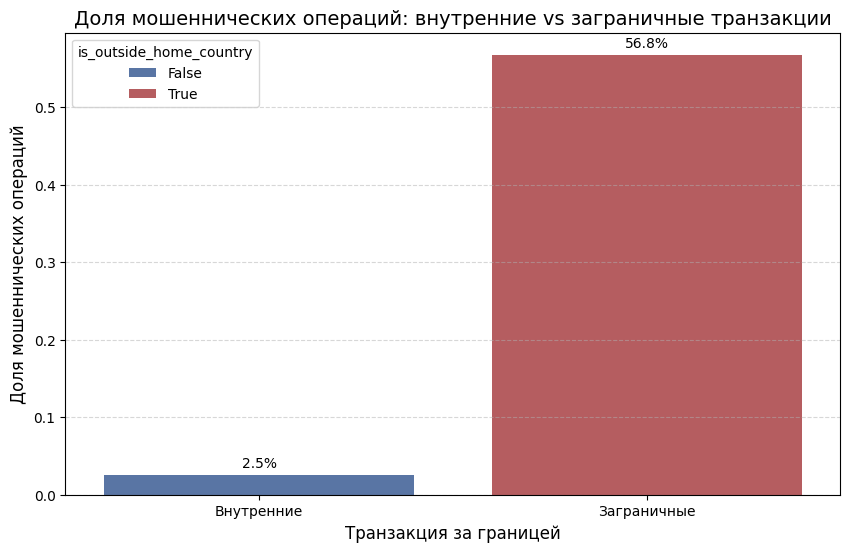

In [11]:
plt.figure(figsize=(10, 6))
fraud_by_country = transaction_data.groupby('is_outside_home_country')['is_fraud'].mean().reset_index()
sns.barplot(x='is_outside_home_country', y='is_fraud', hue='is_outside_home_country', data=fraud_by_country,
            palette={False: '#4c72b0', True: '#c44e52'}, estimator=np.mean)
plt.title('Доля мошеннических операций: внутренние vs заграничные транзакции', fontsize=14)
plt.xlabel('Транзакция за границей', fontsize=12)
plt.ylabel('Доля мошеннических операций', fontsize=12)
plt.xticks([0, 1], ['Внутренние', 'Заграничные'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Добавляем точные значения на столбцы
for index, row in fraud_by_country.iterrows():
    plt.text(index, row['is_fraud']+0.01, f"{row['is_fraud']*100:.1f}%",
             ha='center', color='black')

plt.show()

🔎 Ключевые наблюдения:
1. Операции за пределами страны клиента **значительно** чаще оказываются мошенническими. Как правило, злоумышленники активно используют украденные данные карт за рубежом, пока жертва не заметит подозрительную активность и не заблокирует карту.

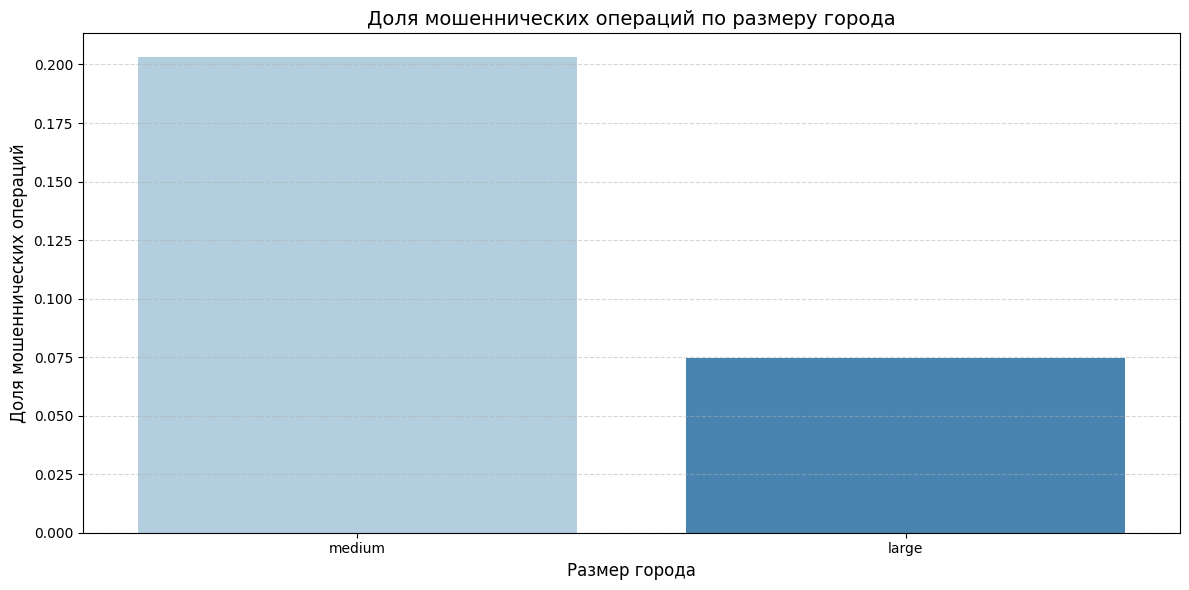

In [12]:
# Оптимизация 1: Предварительная агрегация данных
city_size_fraud = transaction_data.groupby('city_size', observed=True)['is_fraud'].mean().reset_index()

# Оптимизация 2: Использование figure-level функции sns.catplot() для больших датасетов
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='city_size',
    y='is_fraud',
    hue='city_size',
    data=city_size_fraud,  # Используем предварительно агрегированные данные
    order=['medium', 'large'],
    palette='Blues_r',
    estimator=np.mean,
    errorbar=None
)

plt.title('Доля мошеннических операций по размеру города', fontsize=14)
plt.xlabel('Размер города', fontsize=12)
plt.ylabel('Доля мошеннических операций', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

🔎 Ключевые наблюдения:
1. В крупных городах наблюдается иная динамика мошенничества по сравнению со средними. В данном случае, количество мошеннических транзакций в больших городах меньше. Это может быть связано с тем, что в больших городах лучше развиты правоохранительные структуры и уровень жизни граждан выше. С другой стороны, количество транзакций в больших городах так же выше, и отслеживать данные значительно труднее. Это делает полученные результаты противоречивыми.

In [13]:
# 1. Подготовка данных
channel_fraud = (transaction_data.groupby('channel', observed=True)['is_fraud']
                 .agg(['mean', 'count'])
                 .reset_index()
                 .sort_values('mean', ascending=False))

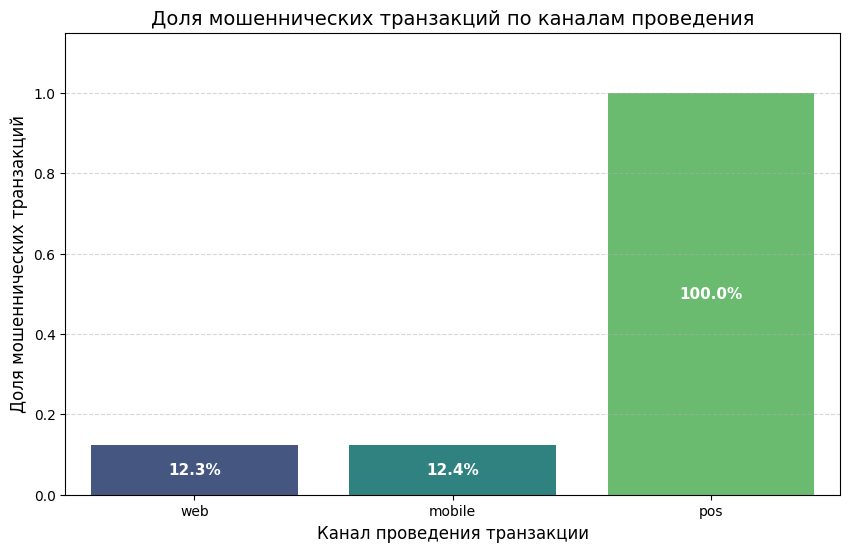

In [14]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='channel', y='mean', hue='channel', data=channel_fraud,
                 palette='viridis_r',
                 order=['web', 'mobile', 'pos'])

plt.title('Доля мошеннических транзакций по каналам проведения', fontsize=14)
plt.xlabel('Канал проведения транзакции', fontsize=12)
plt.ylabel('Доля мошеннических транзакций', fontsize=12)
plt.ylim(0, channel_fraud['mean'].max()*1.15)  # Добавляем 15% сверху для аннотаций

# Аннотации внутри столбцов (белый текст)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()/2,
            f'{p.get_height()*100:.1f}%',
            ha='center', va='center',
            color='white', fontsize=11, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

🔎 Ключевые наблюдения:
1. По графикам видно, что чаще всего мошеннические транзакции совершаются при помощи кассовых устройств. Скорее даже все операции, совершаемые на кассовых аппаратах - мошеннические. Я предполагаю, что подобный результат не говорит о существовании подобной тенденции, а показывает, что выборка недостаточно информативна и полна.    

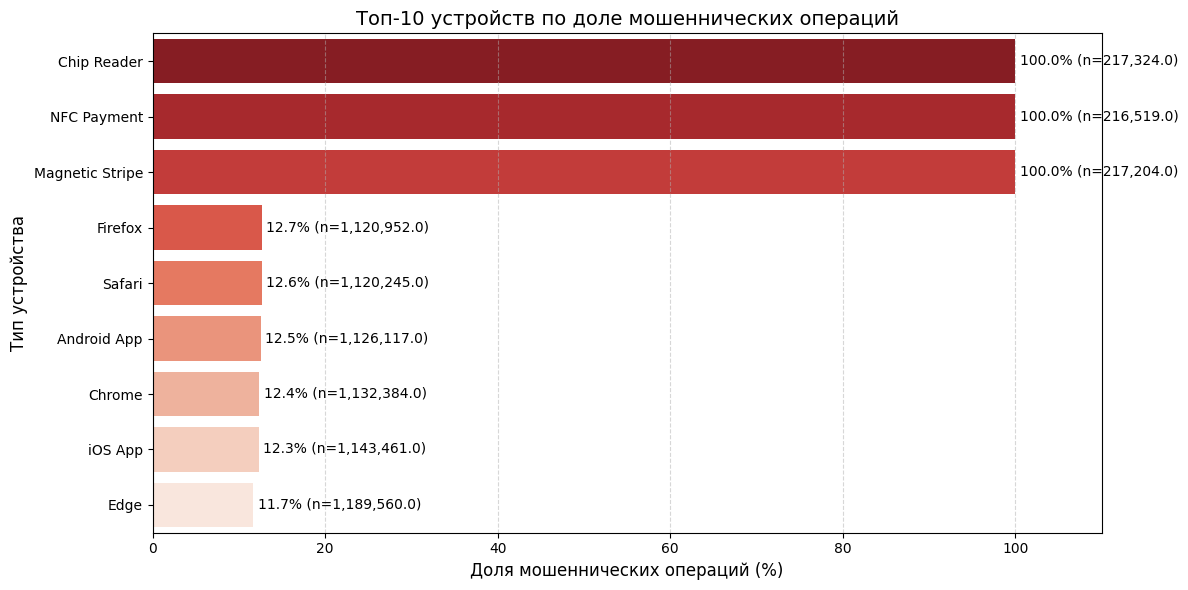

In [17]:
# 1. Подготовка данных: список устройств по доле мошенничества
device_fraud = (transaction_data.groupby('device', observed=True)['is_fraud']
                .agg(['mean', 'count'])
                .sort_values('mean', ascending=False))
device_fraud['mean_pct'] = device_fraud['mean'] * 100

# 2. График доли мошенничества по устройствам
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='mean_pct', y=device_fraud.index, hue=device_fraud.index,
                 data=device_fraud.reset_index(),
                 palette='Reds_r')

plt.title('Топ-10 устройств по доле мошеннических операций', fontsize=14)
plt.xlabel('Доля мошеннических операций (%)', fontsize=12)
plt.ylabel('Тип устройства', fontsize=12)
plt.xlim(0, device_fraud['mean_pct'].max()*1.1)

# Добавляем аннотации с долей и количеством операций
for i, (device, row) in enumerate(device_fraud.iterrows()):
    ax.text(row['mean_pct'] + 0.5, i,
            f"{row['mean_pct']:.1f}% (n={row['count']:,})",
            va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Ценность данных для организации

Анализ предоставленных транзакционных данных выявил ряд ценных инсайтов, которые могут существенно повысить эффективность антифрод-мер и улучшить бизнес-процессы:

- **Выявление ключевых факторов риска мошенничества:**  
  Данные позволяют точно определить, какие признаки (категория вендора, сумма, время, география, размер города) наиболее связаны с мошенничеством. Это даёт возможность строить более точные скоринговые модели и оперативно реагировать на подозрительные операции.

- **Оптимизация антифрод-стратегий:**  
  Благодаря выявленным паттернам (например, высокий риск ночью, при крупных суммах, за рубежом или в определённых категориях) организация может внедрять таргетированные правила и усиливать мониторинг в наиболее уязвимых сегментах.

- **Улучшение клиентского опыта:**  
  Более точное определение мошенничества снижает количество ложных срабатываний, что уменьшает неудобства для добросовестных клиентов и повышает их лояльность.

- **Обоснование инвестиций в технологии и процессы:**  
  Данные дают количественное подтверждение необходимости внедрения современных методов борьбы с дисбалансом классов и использования продвинутых метрик оценки моделей.

- **Возможность сегментации и персонализации:**  
  Организация может сегментировать клиентов и транзакции по уровню риска, что позволяет более гибко управлять лимитами, скорингом и коммуникациями.


**Итог:**  
Данные дают организации мощный инструмент для снижения потерь от мошенничества, повышения эффективности внутренних процессов и улучшения качества обслуживания клиентов.
